- Would it be possible to also provide JupyterLab in the environment? I am used to work in that, and I find the Jupyter notebook interface pretty limiting. Maybe other people prefer JupyterLab as well?
- Watermark (see end of notebook) seems to already be installed in environment. Can it be? Also, will need to provide a version number for oai_analysis_2! :)


- The following function transforms a mask from non-binary into binary. Maybe you already have something like this in your code? If not, feel free to modify it and integrate it! (Written by transforming from itk to numpy and back. Pretty sure there is an itk filter to do that...)

In [1]:
def binarize_mask(mask):
    """
    This function transforms a the values of a mask from floats between 0 and 1 into 0 and 1. Threshold is at 0.5
    
    Parameter
    ---------
    mask: itk image
        Mask containing floats between 0 and 1
    
    Return
    mask: itk image
        Binarized mask
    
    """
    
    THRESHOLD = 0.5
    
    # transforming mask from itk image to numpy array
    mask_np = itk.GetArrayFromImage(mask)
    
    # rounding mask values to closest integer (0 or 1) 
    mask_np = np.floor(mask_np + THRESHOLD)
    
    # transforming from float to int (somehow not working)
    #mask_np = mask_np.astype(int)
    
    # numpy mask back to itk image
    mask = itk.GetImageFromArray(mask_np)
    
    return mask

- The following function visualizes an image sagitally at 2/5, 3/5, and 4/5 with overlapping masks (if present). I think I would like to included it in pyMSK, but I am leaving it here for now. What do you think?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
    
def show_image (img, mask_1 = None, mask_2 = None):
    """
    This function visualizes three slices of an image with overlapping masks. 
    The slices are at 2/5, 3/5, and 4/5 of the sagittal direction.
    If not mask is present, only the image is shown.
    
    Parameters
    ----------
    img : itk image
        Volumetric image
    mask_1: itk image (binarized)
        First mask to overlap
    mask_2: itk image (binarized)
        Second mask to overlap
    """
    
    # parameters for imshow
    n_of_images  = 1 # can be extended to multiple images (each row is an image)
    img_LW       = 4
    figure_width = img_LW * 3
    fig_length   = img_LW * n_of_images
    plt.rcParams['figure.figsize'] = [figure_width, fig_length]
    fig     = plt.figure() 
    n_of_columns = 3
    n_of_rows    = n_of_images
    axis_index   = 1

    # calculating image dimensions to avoid "squeezing" image due to different voxel size
    # get voxel size and image dimension, to calculate extent parameter for imshow
    n_of_voxels = list(itk.size(img))
    voxel_dim = list(itk.spacing(img))
    dim_y = n_of_voxels[0] * voxel_dim[0] // 10
    dim_x = n_of_voxels[2] * voxel_dim[2] // 10
    # calculating "extent" parameter for imshow: first and third value: origin; second value: along x; fourth value: along y
    extent = [0, dim_x, 0, dim_y]
    
    # images from simpleitk to numpy
    img_np    = itk.GetArrayFromImage(img)
    if mask_1 != None:
        mask_1_np = itk.GetArrayFromImage(mask_1)
    if mask_2 != None:
        mask_2_np = itk.GetArrayFromImage(mask_2)
        
    # extract slices at 2/5, 3/5, and 4/5 of the image size
    # if there is not mask, the image where 2/5, 3/5, and 4/5 are calculated is the image,
    # otherwise it's the mask (this is to center the visualization into the mask region)
    if mask_1 == None and mask_2 == None:
        reference_image = img_np
    elif mask_1 != None:
        reference_image = mask_1_np
    else:
        reference_image = mask_2_np    
    size = np.size(img_np,2)
    # get the first slice of the mask in the sagittal direction (the first slice where there is cartilage, not background)
    for b in range(0,int(size/2)):
        current_slice = reference_image[:,:,b]
        if np.sum(current_slice) != 0:
            first_value = b
            break # will take this break away at a certain point
    # get the last slice of the mask in the sagittal direction (the last slice where there is cartilage, before background)
    for b in range(size-1,int(size/2),-1):
        current_slice = reference_image[:,:,b]
        if np.sum(current_slice) != 0:
            last_value = b
            break
    slice_step = int ((last_value-first_value)/4)
    # all slice IDs
    sliceID = (first_value + slice_step, first_value + 2*slice_step, first_value + 3*slice_step)

        
        
    # create the three plots
    for a in range (0,len(sliceID)):

        # create subplot
        ax1 = fig.add_subplot(n_of_rows,n_of_columns,axis_index)

        # image: get slice and show
        slice_img_np   = np.rot90(img_np[:,:,sliceID[a]])
        ax1.imshow(slice_img_np, 'gray', interpolation=None, origin='lower', extent=extent, aspect=1)
        
        # mask_1: get slice and show
        if mask_1 != None:
            slice_mask_1_py   = np.rot90(mask_1_np[:,:,sliceID[a]])
            slice_mask_1_masked = np.ma.masked_where(slice_mask_1_py == 0, slice_mask_1_py)
            ax1.imshow(slice_mask_1_masked, 'hsv' , interpolation=None, origin='lower', extent=extent, aspect=1, alpha=1, vmin=0, vmax=100)
        
        # mask_2: get slice and show
        if mask_2 != None:
            slice_mask_2_py   = np.rot90(mask_2_np[:,:,sliceID[a]])
            slice_mask_2_masked = np.ma.masked_where(slice_mask_2_py == 0, slice_mask_2_py)
            ax1.imshow(slice_mask_2_masked, 'hsv' , interpolation=None, origin='lower', extent=extent, aspect=1, alpha=1, vmin=0, vmax=100)
        
        # title and axis
        ax1.set_title(" Slice: " + str(sliceID[a]))
        ax1.axis('off')
    
        # for extention to multiple images
        axis_index = axis_index + 1



---
---

# Segmenting knee images

Code authors: Hastings T. Greer, ...  
Narrative authors: Serena Bonaretti, Hastings T. Greer, ...  
Code under the xxx Licence  
Narrative under the Creative Commons Attribution license CC-BY 4.0  
---


In this notebook, we segment one image of the OAI dataset using the method described in the paper xyz. Briefly, segmentation is performed using a deep neural network, where ...

--- 
- Imports

In [4]:
import os
import itk
import itkwidgets

import parent
from test.tests import TEST_DATA_DIR
# from test.tests import download_test_data
# download_test_data()

import oai_analysis_2
import time 

## 1. Loading and visualizing image 

- Loading the image from the workign directory:

In [5]:
image = itk.imread(os.path.join(TEST_DATA_DIR, "colab_case/image_preprocessed.nii.gz"))

- Visualizing three image slices (istantaneous):

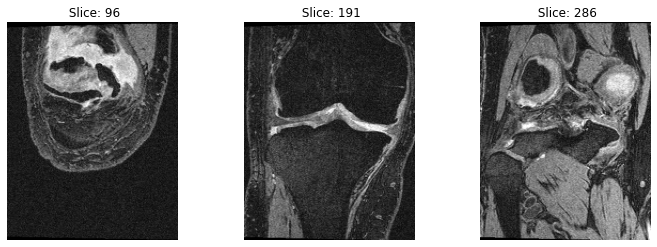

In [6]:
show_image(image)

- Visualizing image 3D (it might take a few seconds):

In [7]:
itkwidgets.view(image)

Viewer(gradient_opacity=0.22, rendered_image=<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'it…

## 2. Segmenting image 
- Segmenting an image will take about 4 seconds on an Nvidia GPU (xyz), or about 1 hour on personal computer
- The code below will automatically detect whether a Nvidia GPU is available, and thus compute the segmentation on either GPU (if present) or CPU

In [8]:
start = time.time()

# run the segmentation
obj = oai_analysis_2.AnalysisObject()

# getting the masks
fc, tc = obj.segment(image)

end = time.time()
print ("Time to create mask:", (end-start)/60, "minutes" )    

Loading parameter file = /Users/sbonaretti/Dropbox/Work/projects/pykneer/code/python/oai_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint '/Users/sbonaretti/Dropbox/Work/projects/pykneer/code/python/oai_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint '/Users/sbonaretti/Dropbox/Work/projects/pykneer/code/python/oai_analysis_2/data/segmentation_model.pth.tar' (epoch 600)
Time to create mask: 61.36497900088628 minutes


In [9]:
# transforming masks into binary
fc_bin = binarize_mask(fc)
tc_bin = binarize_mask(tc)

## 3. Saving masks 
- Masks are saved as (what format shall we use again? Got lost in discussions...)

In [10]:
#import SimpleITK as sitk
fc_file_name = "colab_case/fc.mha"
itk.imwrite(fc_bin, os.path.join(TEST_DATA_DIR, fc_file_name))

In [11]:
tc_file_name = "colab_case/tc.mha"
itk.imwrite(tc_bin, os.path.join(TEST_DATA_DIR, tc_file_name))

## 4. Visualizing masks

- Visualizing three image slices (istantaneous):

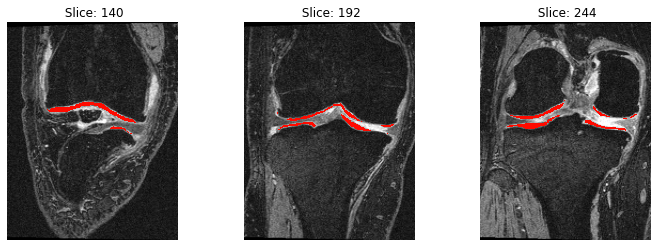

In [16]:
show_image(image,fc_bin,tc_bin)

- Visualizing image 3D (it might take a few seconds):

In [13]:
itkwidgets.view(fc)

Viewer(gradient_opacity=0.22, rendered_image=<itk.itkImagePython.itkImageD3; proxy of <Swig Object of type 'it…

In [14]:
itkwidgets.view(tc)

Viewer(gradient_opacity=0.22, rendered_image=<itk.itkImagePython.itkImageD3; proxy of <Swig Object of type 'it…

##  Dependencies

For reproducibility 

In [15]:
%load_ext watermark
%watermark -v -m -p oai_analysis_2,itk
print (" ")
%watermark -u -n -t -z 

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.27.0

oai_analysis_2: unknown
itk           : 5.2.1.post1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

 
Last updated: Tue Oct 05 2021 17:37:33CEST

